- [Hotel Booking Demand & Pricing](#-hotel-booking-demand--pricing)
- [Metadata](#-metadata)
- [Deep Dive](#-deep-dive)
    - [Setup & Data Preparation](#-setup--data-preparation)
    - [Data Cleaning & Preparation](#-data-cleaning--preparation)
        - [Data Accuracy & Integrity](#-data-accuracy--integrity)
        - [Handling Missing Data](#-handling-missing-data)
        - [Duplicate Data Detection](#-duplicate-data-detection)
        - [Validating Data Types](#-validating-data-types)
        - [Outlier Detection](#-outlier-detection)
    - [Inserting Processed Data into Database](#-inserting-processed-data-into-database)
        - [Creating the Database](#-creating-the-database)
        - [Connecting to PostgreSQL](#-connecting-to-postgresql)
        - [Creating the Table](#-creating-the-table)
        - [Inserting Data into the Table](#-inserting-data-into-the-table)

# Overview

Understanding hotel booking demand is crucial for optimizing pricing strategies, minimizing cancellations, and maximizing revenue. Hotel reservations fluctuate based on seasonal trends, booking lead time, and customer preferences. Pricing decisions directly impact demand, as competitive rates can attract more bookings, while cancellation patterns influence revenue forecasting and inventory management. Analyzing these factors allows hotels to adjust their pricing dynamically, improve occupancy rates, and implement strategies to reduce cancellations.

Our analysis focuses on cancellation behavior and pricing strategies to identify patterns that impact hotel revenue and operational efficiency. By examining key factors such as lead time, market segment, and previous cancellations, we can provide actionable insights to help hotels mitigate revenue losses. Additionally, we perform average Daily Rate (ADR) forecasting to predict future booking trends, enabling hotels to optimize pricing, staffing, and resource allocation. Accurate forecasting enhances decision-making, reduces uncertainty, and ensures better financial planning for the hospitality industry.

<span style="font-size: 20px;">**Dataset**

We are using the publicly available hotel booking demand dataset from [Kaggle](https://www.kaggle.com/datasets/jessemostipak/hotel-booking-demand), which contains three years of reservation data for two hotels in Portugal. This dataset provides detailed insights into bookings, cancellations, customer demographics, and pricing, making it valuable for demand forecasting and revenue optimization.



# Metadata

## Dataset Metadata: Hotel Booking Records

This dataset contains detailed information on hotel bookings, covering various aspects of reservations, customer behavior, and hotel operations.

---

#### 1️⃣ Hotel & Booking Details
- **hotel**: Type of hotel—`H1` (Resort Hotel) or `H2` (City Hotel).  
- **is_canceled**: Indicates whether the booking was canceled (`1`) or not (`0`).  
- **lead_time**: Number of days between the booking date and the arrival date.  
- **arrival_date_year**: Year of arrival.  
- **arrival_date_month**: Month of arrival.  
- **arrival_date_week_number**: Week number of the year corresponding to the arrival date.  
- **arrival_date_day_of_month**: Day of the month of arrival.  

---

#### 2️⃣ Stay Information
- **stays_in_weekend_nights**: Number of weekend nights (**Saturday or Sunday**) booked.  
- **stays_in_week_nights**: Number of weekday nights (**Monday to Friday**) booked.  

---

#### 3️⃣ Guest Information
- **adults**: Number of adults in the booking.  
- **children**: Number of children in the booking.  
- **babies**: Number of babies in the booking.  

---

#### 4️⃣ Meal & Dining Preferences
- **meal**: Type of meal plan selected:
  - `SC` (No meal package)  
  - `BB` (Bed & Breakfast)  
  - `HB` (Half board – breakfast + one meal)  
  - `FB` (Full board – breakfast, lunch, and dinner)  

---

#### 5️⃣ Customer Demographics
- **country**: Country of origin (ISO 3155–3:2013 format).  
- **is_repeated_guest**: Indicates if the customer is a returning guest (`1`) or a first-time visitor (`0`).  

---

#### 6️⃣ Booking Channels & Market Segments
- **market_segment**: Classification of how the booking was made (e.g., `TA` for Travel Agents, `TO` for Tour Operators).  
- **distribution_channel**: The channel through which the booking was made (e.g., `TA` for Travel Agents, `TO` for Tour Operators).  
- **agent**: Identifier of the travel agency that facilitated the booking.  
- **company**: Identifier of the company responsible for the booking payment (if applicable).  

---

#### 7️⃣ Customer Booking History
- **previous_cancellations**: Number of previously canceled bookings by the customer.  
- **previous_bookings_not_canceled**: Number of previous bookings completed without cancellation.  

---

#### 8️⃣ Room Allocation & Modifications
- **reserved_room_type**: Originally reserved room type (encoded for anonymity).  
- **assigned_room_type**: Final room type assigned to the customer (may differ due to overbooking or special requests).  
- **booking_changes**: Number of changes made to the booking after the initial reservation.  

---

#### 9️⃣ Payment & Deposit Details
- **deposit_type**: Indicates whether a deposit was made to confirm the booking:
  - `No Deposit` – No prepayment required  
  - `Non-Refundable` – Deposit was paid but not refundable  
  - `Refundable` – Deposit paid with the possibility of refund  

---

#### 🔟 Waiting List & Customer Type
- **days_in_waiting_list**: Number of days the booking remained on the waiting list before confirmation.  
- **customer_type**: Classification of the booking type:
  - `Contract` – Associated with pre-negotiated allotments  
  - `Group` – Part of a larger group booking  
  - `Transient` – Independent booking with no group affiliation  
  - `Transient-party` – Transient booking linked to at least one other transient booking  

---

#### 1️⃣1️⃣ Pricing & Special Requests
- **adr (Average Daily Rate)**: Total revenue per occupied room per night.  
- **required_car_parking_spaces**: Number of parking spaces requested.  
- **total_of_special_requests**: Total number of additional customer requests (e.g., high floor, twin beds).  

---

#### 1️⃣2️⃣ Reservation Status & Timeline
- **reservation_status**: Final status of the booking:
  - `Canceled` – The customer canceled the reservation.  
  - `Check-Out` – The customer completed their stay.  
  - `No-Show` – The customer did not check in and did not provide prior notice.  
- **reservation_status_date**: The date when the last reservation status was updated, useful for analyzing booking cancellations and check-outs.  

# Deep Dive

## Setup & Data Preparation

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#import cufflinks as cf
#import plotly.graph_objects as go
import warnings
warnings.filterwarnings("ignore")

In [277]:
import os
import zipfile
import shutil


# Dynamically finding the project root (going up until a folder containing "data" is found)
base_path = os.getcwd()

while not os.path.exists(os.path.join(base_path, "data")) and base_path != os.path.dirname(base_path):
    base_path = os.path.dirname(base_path)  # Move up one level

# If no "data" folder is found, assume the project root is the current working directory
project_path = base_path if os.path.exists(os.path.join(base_path, "data")) else os.getcwd()

# Defining paths based on the detected project root
data_folder = os.path.join(project_path, "data")
os.makedirs(data_folder, exist_ok=True)  # Ensuring "data" folder exists

zip_file_path = os.path.join(data_folder, "hotel-booking-demand.zip")
csv_file_path = os.path.join(data_folder, "hotel_bookings.csv")

# Removing any "Downloads" folder inside the project (if it exists)
downloads_path = os.path.join(project_path, "Downloads")
if os.path.exists(downloads_path):
    shutil.rmtree(downloads_path)

# Checking if the dataset is already extracted; if not, download & extract
if not os.path.exists(csv_file_path):
    print("Dataset not found locally. Downloading and extracting...")

    # Downloading the dataset using Kaggle API
    !kaggle datasets download -d jessemostipak/hotel-booking-demand -p "{data_folder}"

    # Extracting the ZIP file
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(data_folder)

# Loading CSV into a Pandas DataFrame
df = pd.read_csv(csv_file_path)

In [ ]:
# df = pd.read_csv('hotel_bookings.csv',parse_dates = True)

## Data Cleaning & Preparation

- Conduct a deep conceptual and logical analysis to assess data accuracy and integrity.

- Check data types for consistency and resolve any discrepancies.

- Detect and remove duplicate records to ensure uniqueness.

- Detect and evaluate missing values and determine the appropriate action.

- Handle missing data based on context by either removing or imputing values.

- Identify and address outliers to prevent distortion in the analysis.

### Data Accuracy & Integrity

Based on the metadata and the nature of the data, several potential issues and recommendations for better data validation and understanding have been identified. These checks help flag inconsistencies, outliers, and potential data entry errors. We detect these inconsistencies and categorize them into predefined categories—critical, inconsistency, and anomaly detection. The categorization helps prioritize the necessary actions, which will be defined further in this section.

In [16]:
df.head(5)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [14]:
df.shape

(119390, 32)

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

Some of the data types need to be changed; for example, children should be int64 instead of float64. However, we address data types after handling missing values, as applying type changes to null values can result in errors.

<span style="font-size: 22px;">**Inconsistency Importance Categorization:**

- **Critical Errors** (e.g., bookings with no guests, negative ADR) → Remove
- **Inconsistencies** (e.g., mismatched room types for cancellations) → Impute or Correct
- **Anomaly Detection** (e.g., excessive booking changes) → Flag for Further Review

Below are the identified inconsistencies, their corresponding categories, and the actions taken to address them:

<span style="font-size: 18px;">**Adults, Children, and Babies**

There should not be a case where all three variables — adults, children, and babies — are zero. A valid booking should involve at least one guest. If all three are zero, it suggests incorrect or missing data.
Check: If adults == 0, children == 0, and babies == 0, this is likely an issue that should be flagged or removed.

In [19]:
invalid_guests = df[(df['adults'] == 0) & (df['children'] == 0) & (df['babies'] == 0)]

**Category:**
Critical Error

Justification: A booking must include at least one guest. Rows where adults, children, and babies are all zero indicate incorrect data and should be removed.

In [20]:
df = df[~((df['adults'] == 0) & (df['children'] == 0) & (df['babies'] == 0))]

<span style="font-size: 18px;">**Lead Time and Booking Date**

The lead time (the number of days between booking date and arrival date) should make sense in the context of the booking date and arrival date. For instance, if the booking date is after the arrival date, it’s an error. A very short lead time (e.g., booking made on the day of arrival) is also worth reviewing.

It should be checked that the lead_time is a non-negative value.

In [21]:
invalid_lead_time = df[df['lead_time']<0]

**Category: Inconsistency**

Justification: The booking_date should always be before or on the arrival_date. Rows where lead time is negative should be flagged for review.

<span style="font-size: 18px;">**Negative ADR**

The Average Daily Rate (ADR) is a key metric in the hospitality industry used to assess the average revenue earned per available room per day.

ADR is calculated by dividing the total revenue generated from all hotel bookings for a given period by the total number of nights all guests stayed at the hotel during the same period. In theory, this value cannot be negative because the minimum income will be zero, as costs and expenses are not included in this calculation. 

If ADR is negative, it indicates that there’s an issue with the data or calculation.

In [22]:
invalid_adr = df[df['adr'] < 0]

**Category:** 
Critical Error

Justification: A negative ADR is impossible in a real-world scenario. These rows should either be removed or corrected if the error is systematic.

In [23]:
df = df[df['adr'] >= 0]

<span style="font-size: 18px;">**Overlapping Cancellations and No-Show**

There should be no cases where the booking is both canceled and marked as a No-Show. A canceled booking should not have a No-Show status, as it implies the guest did not show up due to a cancellation.

Ensuring consistency in booking status is crucial for maintaining data integrity, especially when the objective is to forecast cancellation patterns.

In [24]:
conflicting_status = df[(df['is_canceled'] == 1) & (df['reservation_status'] == 'No-Show')]

**Category:** 
Inconsistency

Justification: A reservation cannot be both canceled and a No-Show simultaneously. This inconsistency needs correction.

In [25]:
df.loc[(df['is_canceled'] == 1) & (df['reservation_status'] == 'No-Show'), 'reservation_status'] = 'Canceled'

<span style="font-size: 18px;">**Booking Changes**

If a booking has multiple changes (e.g., booking_changes > 0), it should be reasonable. If there are excessive changes (e.g., booking_changes greater than a certain threshold like 10), it might suggest either incorrect data entry or a highly unusual case that should be reviewed.

In [26]:
high_changes = df[df['booking_changes'] > 10]

**Category:**
Anomaly Detection

Justification: While some changes are normal, more than 10 changes is highly unusual and should be flagged for further review.

<span style="font-size: 18px;">**Repeated Guest and Previous Bookings**

If a customer has many previous bookings that were not canceled (which indicates they’ve been to the hotel before), it might be unusual for them not to be a repeated guest (i.e., is_repeated_guest == 0). This would be inconsistent because someone who has booked and showed up many times is likely a repeated guest.

A customer may have made a reservation but visited the hotel before the booking date for another reason. In such rare cases, allowing for a single exception is reasonable. Therefore, we use previous_bookings_not_canceled > 1 and is_repeated_guest = 0 instead of previous_bookings_not_canceled > 0 and is_repeated_guest = 0 to account for these rare occurrences.

In [27]:
inconsistent_guest_info = df[(df['is_repeated_guest'] == 0) & (df['previous_bookings_not_canceled'] > 1)]

**Category:** Inconsistency

Justification: A customer with more than one previous bookings should be identified as repeated guest.

In [28]:
df.loc[((df['is_repeated_guest'] == 0) & (df['previous_bookings_not_canceled'] > 1)), "is_repeated_guest"]=1

<span style="font-size: 18px;">**Booking by Group vs. Individual**

There should not be a case where a Group booking (customer_type == 'Group') has only one guest. A group booking should involve multiple guests. If customer_type == 'Group' and adults == 1, this should be flagged as an issue.

In [29]:
group_with_one_guest = df[(df['customer_type'] == 'Group') & (df['adults'] == 1)]

**Category:** Inconsistency

Justification: A group booking should involve multiple guests. If customer_type == 'Group' but only one adult is listed, the data is inconsistent. We replace 'Group' with the most frequent category of customer_type which is 'Transient'

In [30]:
df.loc[(df['customer_type'] == 'Group') & (df['adults'] <= 1), "customer_type"]= "transient"

<span style="font-size: 18px;">**Deposit Type and Booking Status**

Recommendation: If a customer has a deposit (deposit_type is not No Deposit), but the booking is canceled or marked as a No-Show, the deposit should typically be refunded, except in cases where the deposit is non-refundable. The deposit status is required to align with the booking status.

In [31]:
deposit_issue = df[(df['deposit_type'] != 'No Deposit') & (df['reservation_status'].isin(['Canceled', 'No-Show']))]

**Category:** Anomaly Detection (Possible Business Logic Violation)

Justification: If a booking is canceled or a No-Show, deposits should be refunded unless explicitly non-refundable. These cases should be reviewed.

<span style="font-size: 18px;">**Reservation Status vs Stay**

If a booking has a No-Show status or the customer is cancelled, it should not have any stay nights (stays_in_weekend_nights or stays_in_week_nights should be zero).

In such cases, the arrival date remains but isn't used for calculating the stay duration.
The assigned room type must match the reserved room type.

In [32]:
invalid_cancellation = df[((df['is_canceled'] == 1) | (df['reservation_status'] == 'No-Show')) & 
                         ((df['assigned_room_type'].astype(str) != df['reserved_room_type'].astype(str)) |
                          (df['stays_in_week_nights'] > 0) | 
                          (df['stays_in_weekend_nights'] > 0))]

**Category:** Inconsistency 

Justification: The issue arises from a logical inconsistency in how canceled or no-show bookings are treated in the data. A canceled or no-show booking should not have any recorded stay nights (both weekday and weekend), as the guest did not stay at the hotel.

In [33]:
df.loc[(((df['is_canceled'] == 1) | (df['reservation_status'] == 'No-Show')) & 
                    (df['assigned_room_type'].astype(str) != df['reserved_room_type'].astype(str))), "stays_in_week_nights"]=0

df.loc[(((df['is_canceled'] == 1) | (df['reservation_status'] == 'No-Show')) & 
                    (df['assigned_room_type'].astype(str) != df['reserved_room_type'].astype(str))), "stays_in_weekend_nights"]=0

<span style="font-size: 18px;">**Special Requests**

The total_of_special_requests column should typically not have excessively high values, as most guests would request 1 or 2 things (e.g., a high floor, twin beds). If there are unusually high values, it could indicate an error or a large group booking with specific requirements.

In [34]:
high_special_requests = df[(df['total_of_special_requests'] > 5) & (df['customer_type'] != 'Group')]

**Category:** Anomaly Detection

Justification: Flag records with unusually high special requests for further inspection, as they might indicate incorrect data or rare cases that need validation.

<span style="font-size: 18px;">**Market Segment vs Channel**

While market segments and channels may overlap, they serve distinct purposes.

- Channel refers to the medium used for booking. For example, did the guest book through the hotel's website, an OTA (Online Travel Agency), or by calling the hotel directly?

- Market Segment focuses on the characteristics and behavior of the guest rather than the booking method. For instance, a business traveler falls under the "Corporate" segment, regardless of whether they booked via the website, GDS (Global Distribution System), or a direct call. Market segments are typically determined by the rate code a guest books, which can be accessed through multiple channels.

There are cases of overlap. For example, a leisure traveler booking through an OTA is classified under the "OTA" market segment. 

**Why does this distinction matter?** OTA bookings usually come with higher costs than direct bookings. To optimize revenue, segmentation strategies should encourage direct leisure bookings over OTA bookings. Achieving this requires a more detailed and precise approach to market segmentation.

<span style="font-size: 18px;">**arrival_date_week_number:** 

The arrival_date_week_number column represents the week number of the year for the arrival date. We observe week number 53, which does not make sense as a year has 52 weeks. However, it is possible to encounter 53 weeks in some years due to the way weeks are calculated, specifically in systems that use the ISO 8601 standard.

Why does this happen?

The ISO 8601 system assigns weeks to years, and a year can have 53 weeks if:
- January 1st is a Thursday, or
- The year starts on a Wednesday, and the year is a leap year.

In both cases, the extra week happens because the first day of the year (or the first few days of the year) can still belong to the last week of the previous year, leading to a total of 53 weeks in that year.

<span style="font-size: 18px;">**arrival_date_month**

The arrival_date_month column contains month names as strings, which are not inherently ordered. To ensure clarity and consistency, we explicitly define their correct chronological order before mapping them to numerical values. This prevents potential confusion in future processing where numerical month values might be needed, ensuring January is always 1, February is 2, and so on.

In [35]:
# Ensuring that the ordered_months list is in the correct order before mapping
ordered_months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

# Sorting 'arrival_date_month' column based on the ordered month list
df['arrival_date_month'] = pd.Categorical(df['arrival_date_month'], categories=ordered_months, ordered=True)

df = df.sort_values(by='arrival_date_month')

#df['arrival_date_month'] = df['arrival_date_month'].astype('object')

In [36]:
# Ensuring the column is properly ordered
df['arrival_date_month'] = df['arrival_date_month'].astype('category')
df['arrival_date_month'].cat.categories

Index(['January', 'February', 'March', 'April', 'May', 'June', 'July',
       'August', 'September', 'October', 'November', 'December'],
      dtype='object')

In [37]:
# All good!!!
df['arrival_date_month'] = df['arrival_date_month'].astype('object')

### Handling Missing Data

In [38]:
# checking Null values
null = pd.DataFrame({'Null Values' : df.isnull().sum(), 'Percentage Null Values' : np.round(df.isnull().sum() / (df.shape[0]) * (100), 3) })

In [39]:
null[null["Null Values"]!=0]

,Null Values,Percentage Null Values
children,4,0.003
country,478,0.401
agent,16280,13.657
company,112441,94.323


**Missing Data in 'children' Column (0.003%):** 

We can fill the missing values with 0 (assuming children not being present is a reasonable default value).

In [40]:
df["children"].fillna(0, inplace=True)

**Missing Data in 'country' Column (0.409%):**

Since the missing values are for a small percentage of bookings, we can either:
- Fill in with the most frequent country (mode), assuming it's a reasonable approximation. (our choice here)
- If the country column is essential for analysis, we might need to investigate why it's missing and consider dropping these rows if they are unimportant.

In [41]:
df["country"].fillna(df['country'].mode()[0], inplace=True)

**Missing Data in 'agent' Column (13.686%):**

This is a large portion of data, and it doesn't make sense to drop them all. 

In this case, we can fill in with a default value, such as "Unknown" or the most frequent agent. Here, we choose to go with assigning a separate agent-ID category to missing values "-1".

In [42]:
df['agent'].fillna('-1', inplace=True)

**Missing Data in 'company' Column (94.307%):**

Since this column has a very high percentage of missing values, we can:

- Drop the column entirely if it's not critical for the analysis. (our choice)
- If it’s important for some reason, we can fill the missing values with a default value, such as "Unknown" or the most frequent company.

In [43]:
df.drop(columns= ['company'], inplace=True)

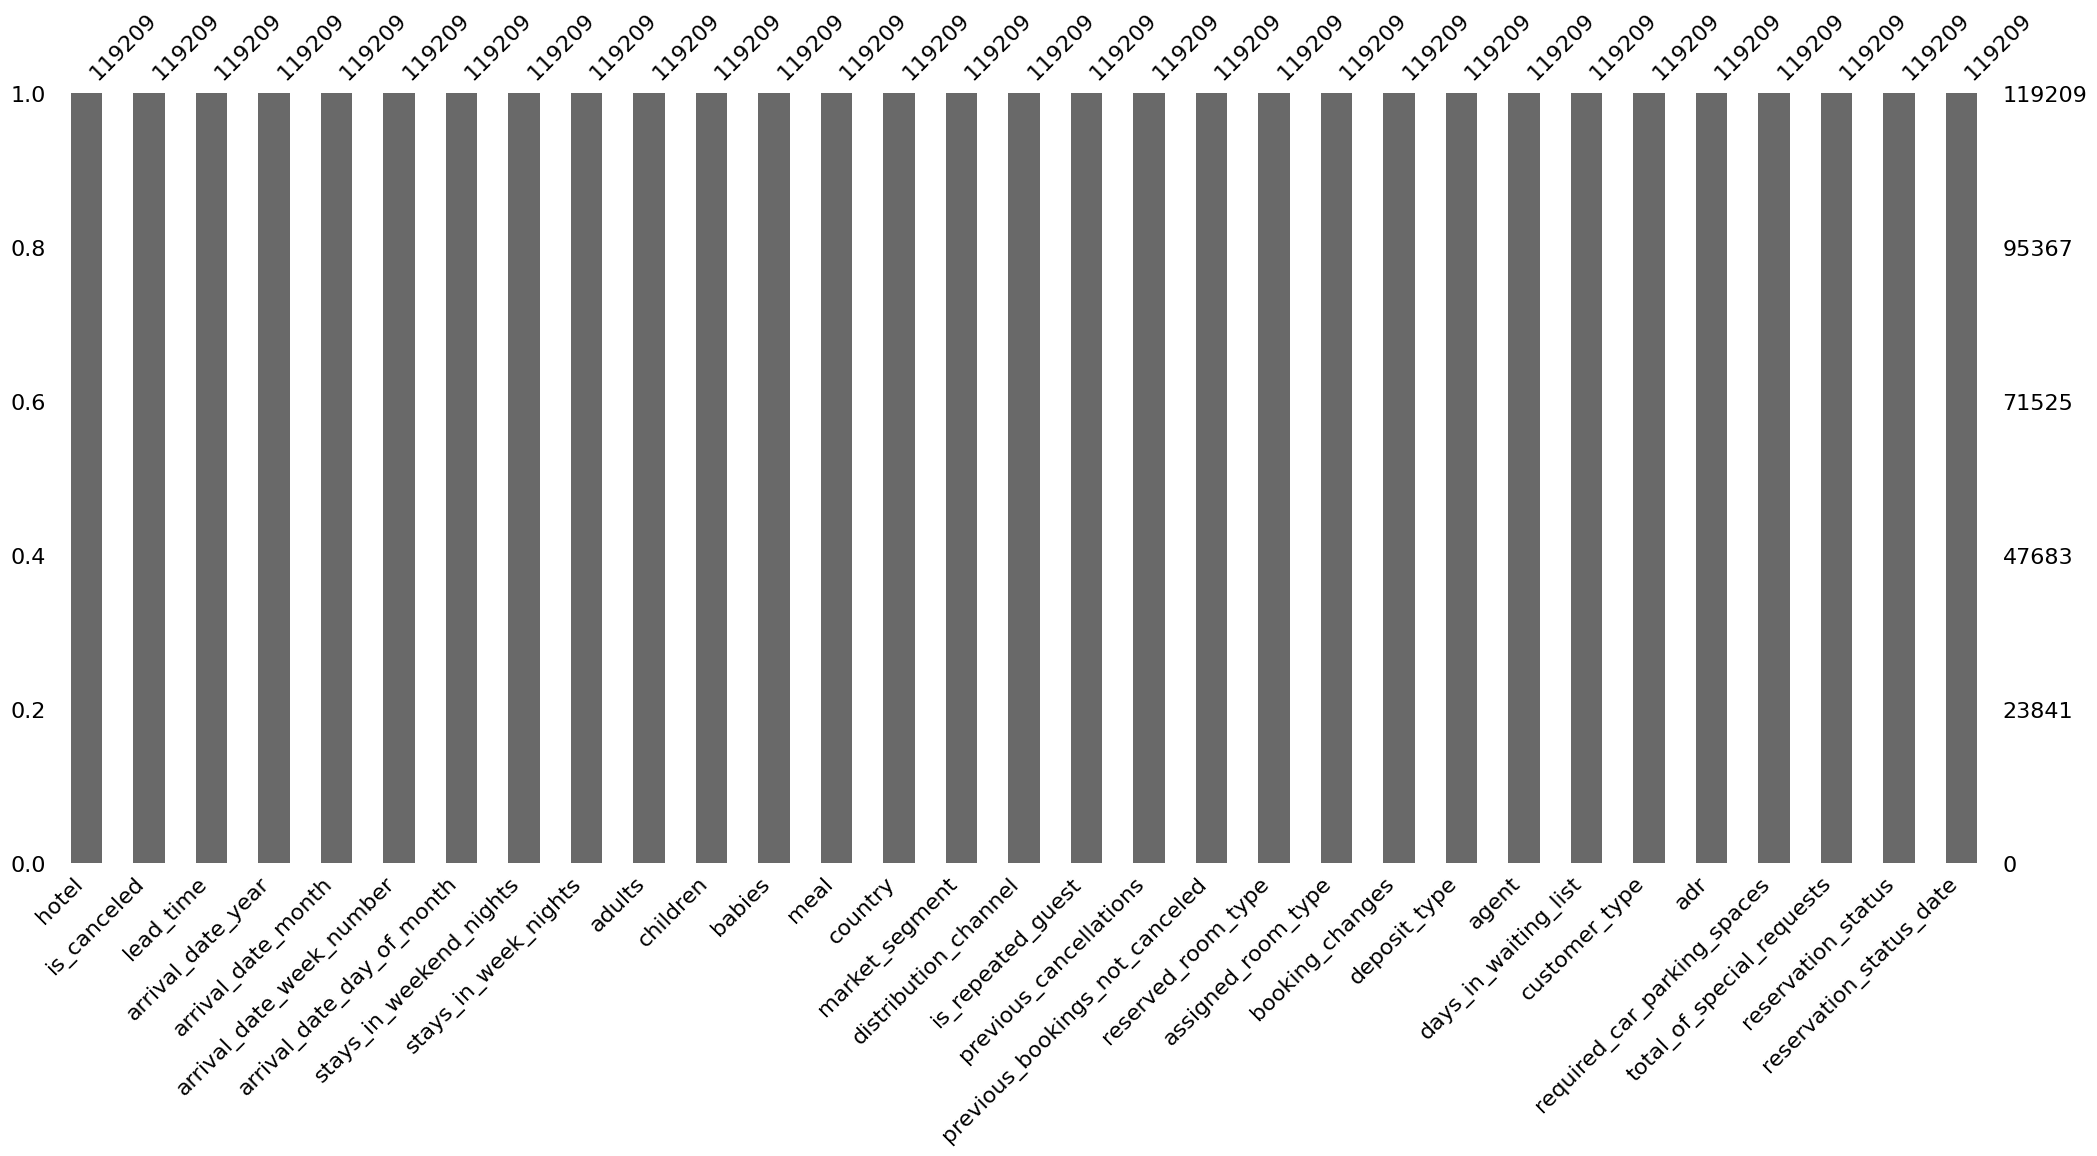

In [44]:
import missingno as msno

msno.bar(df)
plt.show()

There are no missing values in the dataset anymore.

### Duplicate Data Detection

In [45]:
# counting strict duplicated rows ('first' is the default value, excludes the first occurrence and marks the rest as True)
df.duplicated(keep='first').sum()

32013

Strict duplicates are typically system errors, but identifying repeated rows and their patterns can still provide valuable insights. For example, it can help IT teams track why certain rows are entered multiple times, pinpoint the cause of this error, and prevent it from happening in the future. Additionally, analyzing patterns of repetition might reveal issues in the data collection or entry processes and help improve data validation procedures.

By recognizing and addressing these causes, the team can take steps to prevent future duplicates, improve data accuracy, and ensure the data collection or entry processes are functioning correctly. Essentially, even system errors (duplicates) can offer insights into how to optimize and maintain better data quality.

In [46]:
# Finding duplicated rows
duplicates = df[df.duplicated(keep='first')] # keep=False shows all duplicates, keep='first' excludes the first occurrence
columns_list = duplicates.columns.tolist()

# Counting how many times each duplicated row is repeated
duplicate_counts = duplicates.groupby(columns_list).size().reset_index(name='count')
duplicate_counts = duplicate_counts.sort_values(by='count', ascending=False)

# Showing the rows and their respective counts
duplicate_counts[:3]

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,count
5401,City Hotel,1,277,2016,November,46,7,1,2,2,...,Non Refund,-1,0,Transient,100.0,0,0,Canceled,2016-04-04,179
4177,City Hotel,1,68,2016,February,8,17,0,2,2,...,Non Refund,37.0,0,Transient,75.0,0,0,Canceled,2016-01-06,149
5073,City Hotel,1,188,2016,June,25,15,0,2,1,...,Non Refund,119.0,39,Transient,130.0,0,0,Canceled,2016-01-18,108


In [47]:
# keeping the first occurrence and drop the subsequent repetitions
df = df.drop_duplicates(keep='first')

### Validating Data Types

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 87196 entries, 13803 to 30829
Data columns (total 31 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   hotel                           87196 non-null  object 
 1   is_canceled                     87196 non-null  int64  
 2   lead_time                       87196 non-null  int64  
 3   arrival_date_year               87196 non-null  int64  
 4   arrival_date_month              87196 non-null  object 
 5   arrival_date_week_number        87196 non-null  int64  
 6   arrival_date_day_of_month       87196 non-null  int64  
 7   stays_in_weekend_nights         87196 non-null  int64  
 8   stays_in_week_nights            87196 non-null  int64  
 9   adults                          87196 non-null  int64  
 10  children                        87196 non-null  float64
 11  babies                          87196 non-null  int64  
 12  meal                            8

- **reservation_status_date:** object – This should be converted to datetime64[ns] for proper date handling and time-based analysis.
- **children:** float64 – int64 is more appropriate, as it represents a count and should not allow decimals.
- **is_canceled** and  **is_repeated_guest** int64 - They are better represented as an object type as they show True/False binary values.
- **agent** int64 - agent represents the agent IDs which are identifiers, and storing them as objects allows for better clarity in understanding them as distinct entities rather than numeric data.

In [49]:
# Converting reservation_status_date to datetime64[ns]
df['reservation_status_date'] = pd.to_datetime(df['reservation_status_date'])

# Converting children to int64 (we already handled missing values)
df['children'] = df['children'].astype('int64')

df['agent'] = df['agent'].astype('object')

# Converting is_canceled to object 
df["is_canceled"] = df['is_canceled'].astype('object')

# Converting is_repeated_guest to object 
df["is_repeated_guest"] = df['is_repeated_guest'].astype('object')

# Converting specified columns to category
#columns_to_category = ['meal', 'country', 'distribution_channel','reserved_room_type', 'assigned_room_type', 'deposit_type', 'customer_type', 'reservation_status', 'market_segment', 'arrival_date_month', 'is_canceled', 'is_repeated_guest']

#df[columns_to_category] = df[columns_to_category].apply(lambda x: x.astype('category'))

Introducing a unique identifier for the dataset as booking_id:

In [50]:
df['booking_id'] = df.index  # Using the row index as a unique identifier

### Outlier Detection

<span style="font-size: 18px;">Visual display

In [51]:
df_boxplot = df.drop(columns=['booking_id', 'reservation_status_date', 'agent'])

# Creating two empty lists to store numerical and categorical variables.
cat_vars = []
num_vars = []

for column_name in df_boxplot.columns:
    if df_boxplot[column_name].dtype in ['object', 'category']:        
        cat_vars.append(column_name)
    else:
        num_vars.append(column_name)

print(f"Number of Categorical columns: {len(cat_vars)}")
print(f"Number of Numerical columns: {len(num_vars)}\n")

print(f"Categorical columns: {cat_vars}\n")
print(f"Numerical columns: {num_vars}")

Number of Categorical columns: 13
Number of Numerical columns: 16

Categorical columns: ['hotel', 'is_canceled', 'arrival_date_month', 'meal', 'country', 'market_segment', 'distribution_channel', 'is_repeated_guest', 'reserved_room_type', 'assigned_room_type', 'deposit_type', 'customer_type', 'reservation_status']

Numerical columns: ['lead_time', 'arrival_date_year', 'arrival_date_week_number', 'arrival_date_day_of_month', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies', 'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'days_in_waiting_list', 'adr', 'required_car_parking_spaces', 'total_of_special_requests']


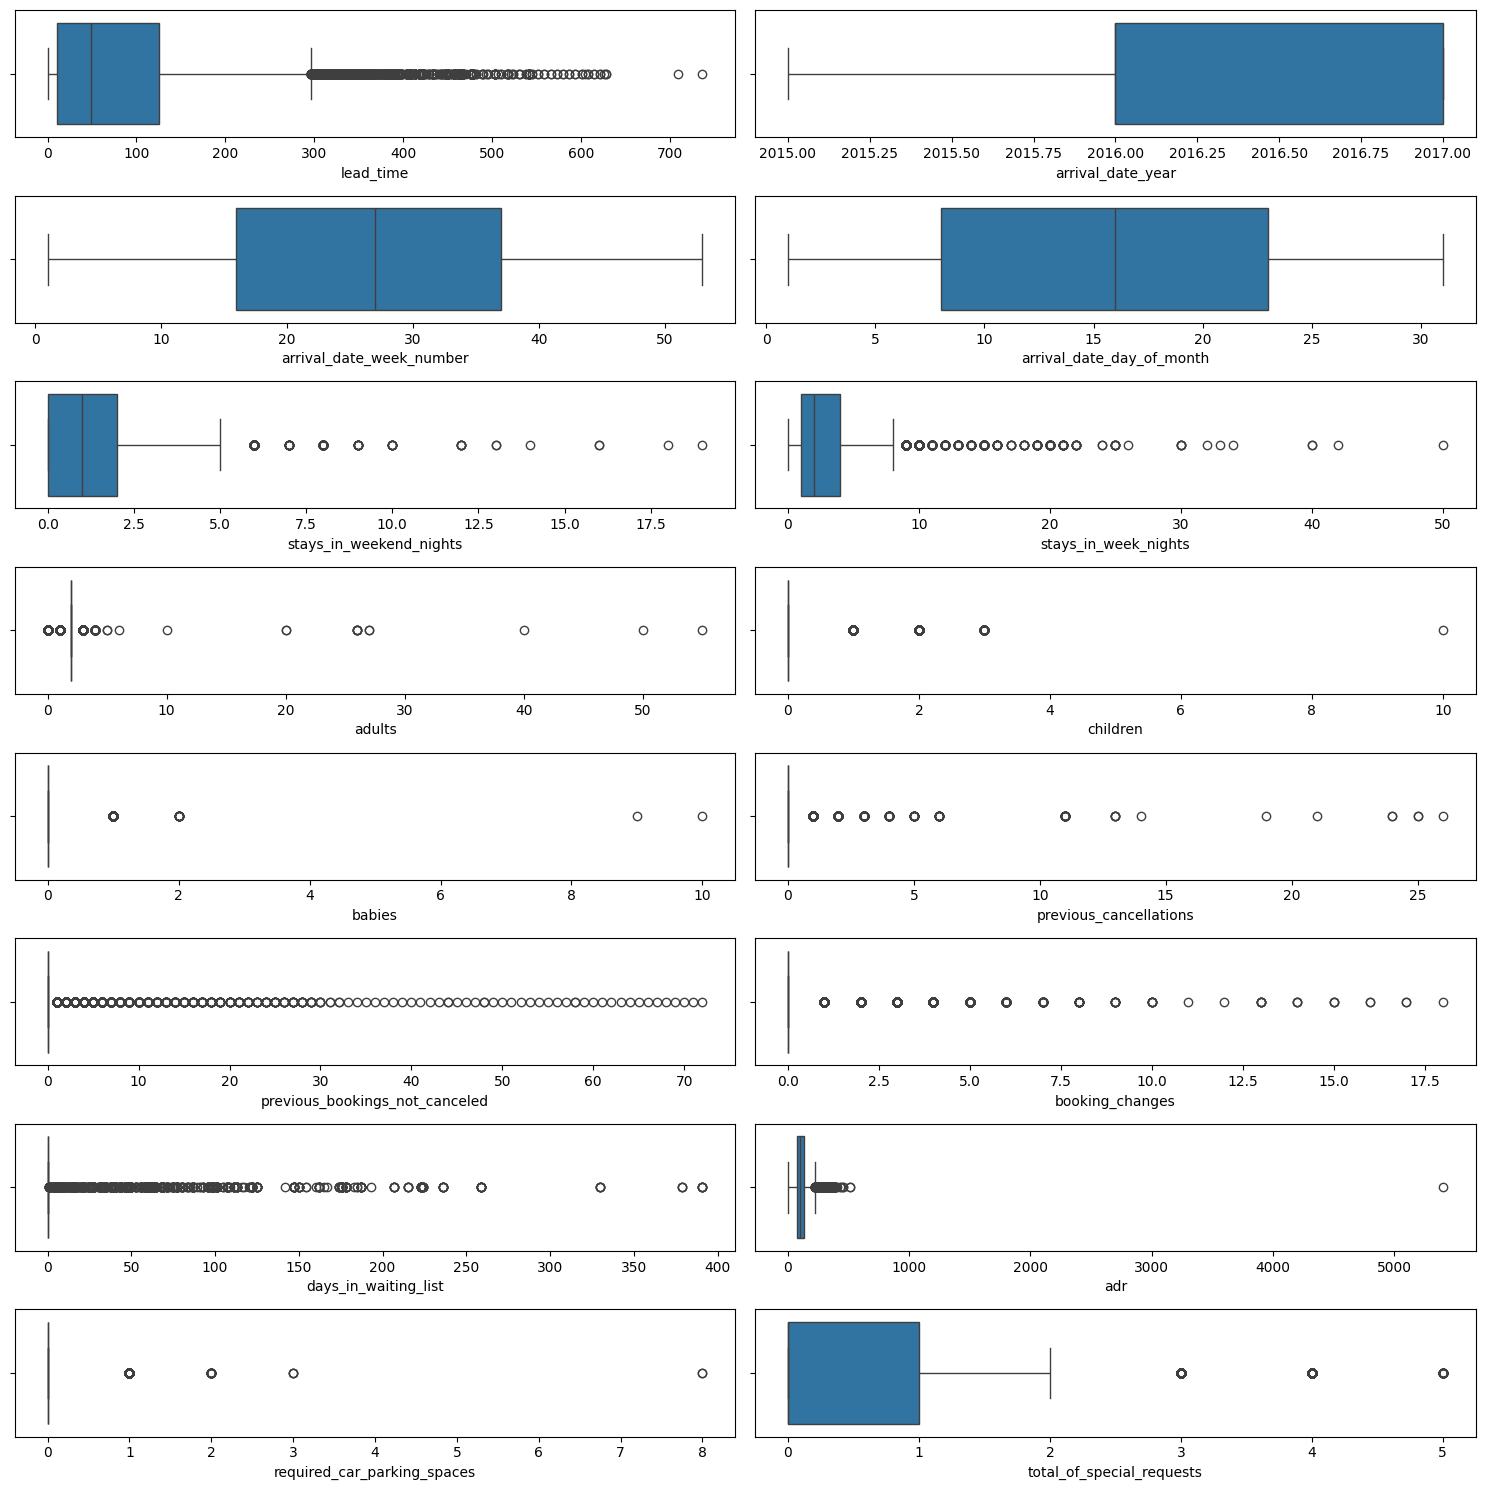

In [52]:
# Setting the figure size
fig, axs = plt.subplots(nrows=8, ncols=2, figsize=(15, 15))
axs = axs.flatten()

# creating box plot for numerical columns
for i, var in enumerate(num_vars):
    sns.boxplot(x=var, data=df, ax=axs[i])
    
    # Labeling axis explicitly
    axs[i].set_xlabel(var)
    #axs[i].set_ylabel('Values')

fig.tight_layout() 
plt.show()

<span style="font-size: 18px;">**Explanation:**

Box plots highlight the outliers for the following columns:

'lead_time', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies', 'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'days_in_waiting_list', 'adr', 'required_car_parking_spaces'

So far, we have visually identified the columns with outliers. Next, we will examine the distribution of these columns. 
If they follow a normal distribution, we can safely use the z-score to detect specific outliers. 

We will check the distribution both visually and using statistical tests.

<span style="font-size: 18px;">Histograms

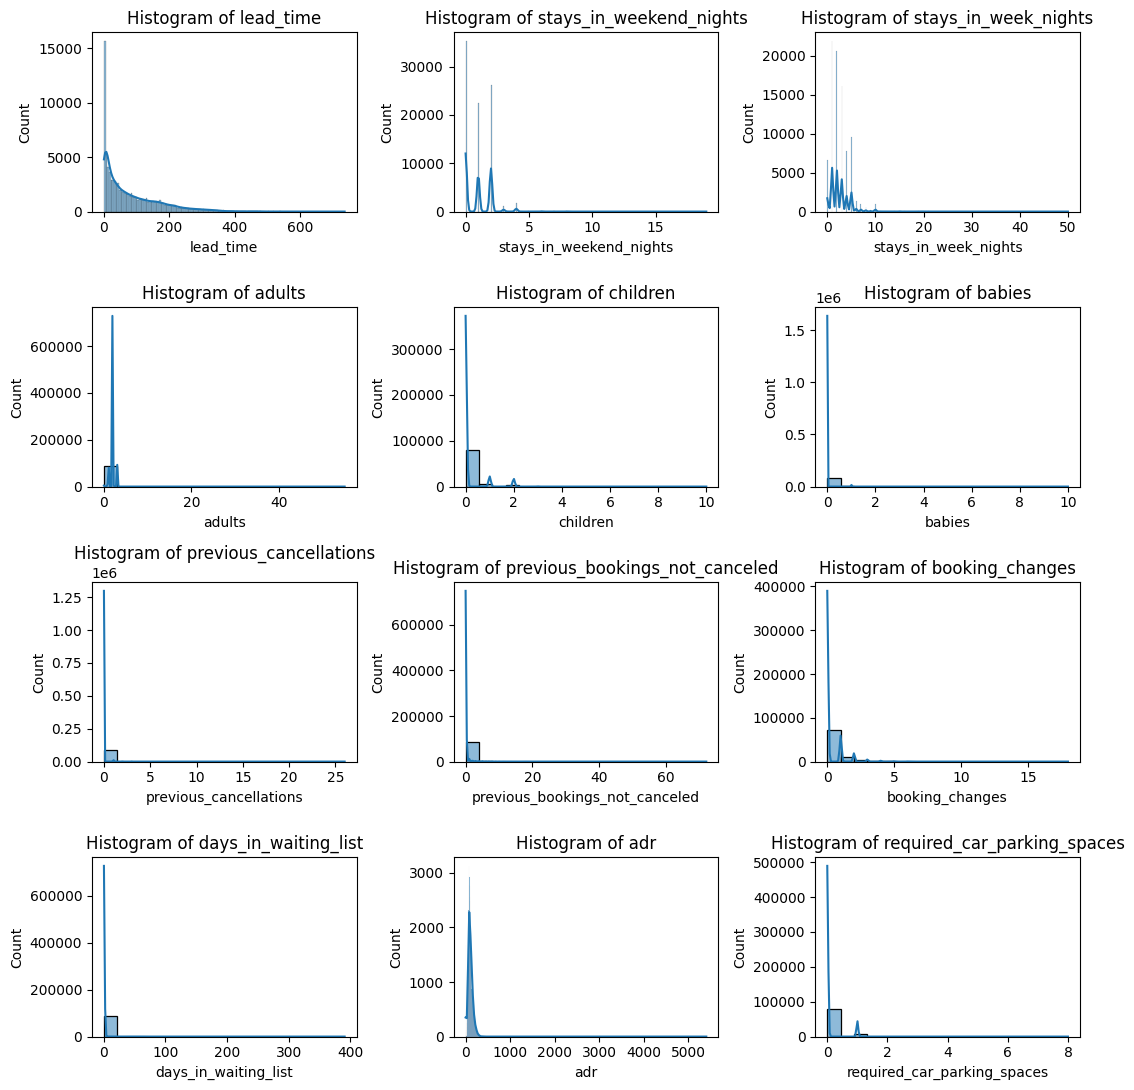

In [53]:
# The columns with potential outliers 
columns_to_plot = ['lead_time', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies',\
'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'days_in_waiting_list', 'adr', \
'required_car_parking_spaces']

# Calculating the number of subplots needed
n_plots = len(columns_to_plot)

# Creating the subplots
fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(11, 11))  
axs = axs.flatten()  

# Creating histograms for each column
for i, col in enumerate(columns_to_plot):
    sns.histplot(df[col], kde=True, ax=axs[i])  
    axs[i].set_title(f'Histogram of {col}')  

# Hiding the last empty subplot if there are only 7 columns
for i in range(n_plots, len(axs)):
    axs[i].axis("off")

plt.tight_layout()  
plt.show()


<span style="font-size: 18px;">Shapiro-Wilk Test statistic

In [54]:
# We use Shapiro-Wilk Test statistic for normality check 
from scipy.stats import shapiro

dict_normal_dist = {}
for col in columns_to_plot:
    stat, p_value = shapiro(df[col].dropna())  # Drop NaN values to avoid errors
    if p_value > 0.05:
        dict_normal_dist[col] = "Normal"
    else:
        dict_normal_dist[col] = "Not Normal"

# Printing columns that are normally distributed
normal_columns = [col for col, status in dict_normal_dist.items() if status == "Normal"]

if normal_columns:
    print(f"Columns that are normally distributed: {normal_columns}\n")
else:
    print("No columns are normally distributed.\n")

No columns are normally distributed.



<span style="font-size: 18px;">**Outlier Detection for Non-normally Distributed Data**

Since the data is not normally distributed, the standard Z-score method does not work well for outlier detection. 
Instead, we should reply on alternative methods suitable for non-normal distributions. We have a wide variety of options. Here, we choose the Percentile-Based method to detect extreme outliers with a high confidence interval (99.9%).

Definition of 99.9% Confidence Interval (Percentile-Based): In this method, the 99.9th percentile is used as the upper bound. Any value above this upper bound is considered an outlier.

Important Note: In this dataset, the columns we are analyzing contain non-negative values, with 0 being considered normal. Therefore, we do not check for the lower bound and focus only on identifying data points that exceed the upper bound.

In [55]:
# Defining upper bound for each column 
upper_bound = df[columns_to_plot].quantile(0.999)  # 99.9th percentile

# Creating a dictionary to store outlier values for each column
outliers_dict = {}

for column in columns_to_plot:
    # Filtering the outliers for each column
    outliers = df[df[column] > upper_bound[column]]
    
    # Adding the outliers as a list to the dictionary
    outliers_dict[column] = outliers[column].tolist()

# Printing the outlier lists for each column
for column, outliers_list in outliers_dict.items():
    print(f"{column} outliers: {outliers_list[:5]}... \n")  # Displaying the first 5 outliers 
    #print(f"{column} outliers:\n {outliers_list}\n")    # Displaying the full list

lead_time outliers: [566, 566, 545, 545, 552]... 

stays_in_weekend_nights outliers: [8, 8, 16, 8, 8]... 

stays_in_week_nights outliers: [20, 21, 40, 22, 21]... 

adults outliers: [4, 4, 4, 4, 4]... 

children outliers: [3, 3, 3, 3, 3]... 

babies outliers: [2, 10, 2, 2, 2]... 

previous_cancellations outliers: [6, 6, 6, 6, 11]... 

previous_bookings_not_canceled outliers: [58, 59, 60, 61, 26]... 

booking_changes outliers: [7, 7, 10, 7, 7]... 

days_in_waiting_list outliers: [185, 185, 223, 187, 187]... 

adr outliers: [5400.0, 336.0, 510.0, 353.0, 342.29]... 

required_car_parking_spaces outliers: [2, 2, 2, 2, 2]... 



<span style="font-size: 16px;">**Observations**

Many of the flagged outliers seem plausible if the dataset includes large group bookings, long-term stays, or special events.
However, some of these outliers (e.g., extremely high values for children, babies, and parking spaces) likely indicate data issues that should be verified.
It's essential to evaluate the context in which these outliers occur, as they may represent rare but valid cases or could signal errors in data entry or processing.

<span style="font-size: 16px;">**Next steps**

- Verify: We should cross-check these outliers with the raw data to ensure they are legitimate.
- Contextual Review: Some outliers (e.g., bookings with very high numbers of children or babies) may need further investigation as they might represent data entry issues.
- Impute or Remove: Depending on the analysis, we may want to either impute or remove some of these outliers if they are determined to be errors or irrelevant for our analysis.

<span style="font-size: 16px;">**Cross-checking with the original dataset (whether the outliers are part of group bookings)**

In [56]:
# First, let's combine the outliers for each column into a single list
outliers_combined = pd.concat([df[df[column] > upper_bound[column]] for column in columns_to_plot])

# Checking if these outliers belong to the 'Group' customer type
outliers_group = outliers_combined[outliers_combined['customer_type'] == 'Group']

# Displaying the outliers that belong to the 'Group' customer type
#print("Outliers associated with 'Group' customer type:\n", outliers_group)

outliers_group.shape

(17, 32)

Group bookings often involve larger volumes and specific booking behaviors that may not apply to individual bookings. These group-related outliers could represent legitimate trends or patterns, making them valuable for analysis. That's why we decided to keep the outliers that are identified as part of group bookings.

For the rest of the outliers, we do not have access to further information, such as data entry practices, which would help determine whether these values are errors or legitimate extreme values. Therefore, we decided to remove the remaining outliers to ensure the integrity of the analysis. It's worth mentioning again that we considered the data above 99.9 percentile as outliers which means extreme cases outside of 99.9% confidence interval.

Now, to remove all outliers except the ones associated with "Group" customer type, we can filter out the general outliers (those exceeding the upper bound) and then keep only the ones that belong to the "Group" category.

In [57]:
# Removing the outliers for all columns
outliers_removed = df[~df.index.isin(outliers_combined.index)]  # Removing all outliers

# Identifying the outliers related to 'Group' customer type
group_outliers = outliers_combined[outliers_combined['customer_type'] == 'Group']

# Combining the non-outlier data with the 'Group' outliers
df = pd.concat([outliers_removed, group_outliers])

# Displaying the final DataFrame with outliers removed except those associated with 'Group'
# print(f "Final DataFrame (with group outliers retained): {final_df}")
df.shape

(86482, 32)

Final check for any remaining extreme values in the data that are illogical or lack a valid explanation.

We redo the same steps we did before to extract the outliers with 99.9% confidence interval.

In [58]:
# Defining upper bound for each column 
upper_bound = df[columns_to_plot].quantile(0.999)  # 99.9th percentile

# Creating a dictionary to store outlier values for each column
outliers_dict = {}

for column in columns_to_plot:
    # Filtering the outliers for each column
    outliers = df[df[column] > upper_bound[column]]
    
    # Adding the outliers as a list to the dictionary
    outliers_dict[column] = outliers[column].tolist()

# Printing the outlier lists for each column
for column, outliers_list in outliers_dict.items():
    #print(f"{column} outliers: {outliers_list[:5]}... \n")  # Displaying the first 5 outliers 
    print(f"{column} outliers:\n {outliers_list}\n")    # Displaying the full list

lead_time outliers:
 [468, 468, 468, 468, 468, 468, 468, 471, 462, 468, 468, 468, 468, 468, 468, 465, 462, 462, 462, 464, 465, 465, 465, 465, 468, 468, 468, 467, 479, 476, 476, 476, 468, 468, 468, 468, 465, 465, 464, 464, 465, 465, 465, 465, 464, 465, 465, 463, 465, 462, 462, 462, 462, 462, 462, 462, 462, 476, 476, 476, 476, 468, 479, 479, 479, 479, 478, 479, 479, 479, 479, 479, 479, 478, 478, 458, 460, 460, 475, 468, 468, 475, 461, 461]

stays_in_weekend_nights outliers:
 [7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7]

stays_in_week_nights outliers:
 [16, 16, 17, 17, 18, 16, 18, 16, 19, 16, 18, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 16, 16, 19, 17, 18, 17, 16, 16, 16, 18]

adults outliers:
 [27, 27, 26, 26, 26, 50, 40, 26, 5, 20, 10, 5, 6, 20, 55, 26]

children outliers:
 [3]

babies outliers:
 []

previous_cancellations outliers:
 [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3,

We observe that there are no illogically extreme values in these columns anymore. 

<span style="font-size: 21px;">**Handling Outliers in Categorical Features**

1. Identify Categorical Features: 
First, we need to identify which columns are categorical. These are typically of types object or category in pandas.

2. Check Value Counts for Categorical Features: 
We’ll check the unique value counts for each categorical feature. If any category has a very low count (such as just a few observations), we’ll consider it as a potential outlier.

3. Define Outlier Criteria: 
We need a clear strategy for what counts as an outlier for categorical data. A typical criterion is:
Categories with fewer than a certain threshold of observations (e.g., 1% of the dataset size) might be considered outliers.

4. Handle Outliers in Categorical Features: 

- Option 1: We’ll group rare categories into a single 0 category. (None of the categories in any of the columns is called 0)
- - Option 2: Alternatively, we can remove rows with extremely rare categories. (We stick with the first option here.)

5. Check the Distribution of Categorical Features: 
After handling outliers, it's a good idea to check the distribution again to ensure the data is balanced and meaningful.

**NOTE**: We identify outliers and make sure the transformed features retain their original data types.

In [59]:
threshold = 0.01  # Categories with fewer than 1% of total records will be considered outliers

# Identifying Categorical Features
categorical_features = [col for col in df.columns if df[col].dtype in ['object', 'category']]

# Removing 'reservation_status_date' from the list if it exists
# This feature is supposed to have datetime format 
# From EDA, we know deposit_type, categories are valid
if 'reservation_status_date' in categorical_features:
    categorical_features.remove('reservation_status_date')
if 'deposit_type' in categorical_features:
    categorical_features.remove('deposit_type')

# Checking Value Counts for Categorical Features
for col in categorical_features:
    print(f"Value counts for {col}:")
    print(df[col].value_counts())
    print("-" * 50)

# Handling Categorical Outliers and Replacing with Integer Code
for col in categorical_features:
    value_counts = df[col].value_counts(normalize=True)  # Getting the proportions of each category
    rare_categories = value_counts[value_counts < threshold].index.tolist()  # Categories with frequency below the threshold
    
    # Replacing rare categories with 0
    df[col] = df[col].apply(lambda x: 0 if x in rare_categories else x)
    df[col] = df[col].astype('object')  # Ensuring the column is of type 'object' for string columns

# Now, df has categorical features handled with outliers replaced by '0' 
# and column types are adjusted for SQL insertion.

print("////" * 30)
print("\\\\\\\\" * 30)

# Checking the New Distribution of Categorical Features
for col in categorical_features:
    print(f"Value counts for {col} after handling outliers:")
    print(df[col].value_counts())
    print("-" * 50)

Value counts for hotel:
hotel
City Hotel      52834
Resort Hotel    33648
Name: count, dtype: int64
--------------------------------------------------
Value counts for is_canceled:
is_canceled
0    62696
1    23786
Name: count, dtype: int64
--------------------------------------------------
Value counts for arrival_date_month:
arrival_date_month
August       11104
July          9959
May           8272
April         7849
June          7727
March         7445
October       6886
September     6603
February      6027
December      5063
November      4940
January       4607
Name: count, dtype: int64
--------------------------------------------------
Value counts for meal:
meal
BB           67346
SC            9366
HB            8939
Undefined      481
FB             350
Name: count, dtype: int64
--------------------------------------------------
Value counts for country:
country
PRT    27398
GBR    10350
FRA     8783
ESP     7207
DEU     5364
       ...  
UMI        1
NIC        1
BDI      


<span style="font-size: 18px;">**Results of Outlier Detection in Categorical Features**

Outliers were detected in the following features and grouped under a category named "Other" within each feature: 

'meal', 'country', 'market_segment', 'distribution_channel', 'reserved_room_type', 'assigned_room_type', 'deposit_type', 'agent', and 'customer_type'.


<span style="font-size: 21px;">**Summary of Data Cleaning & Preparation Steps**

Data cleaning & preparation involved several critical steps to ensure the dataset's accuracy and integrity.

We assessed and corrected any inconsistencies in the data, categorizing them into three groups: **Critical, Inconsistency, and Anomaly detection**. We then addressed these issues based on their importance level and overall business logic. Missing values were handled by either removing or imputing them, depending on the context. To further refine the dataset, we detected and removed any strict duplicate records to ensure uniqueness and accuracy. Lastly, we identified and addressed potential outliers to prevent them from skewing the analysis, ensuring the dataset was clean and ready for further exploration.

In [60]:
# Creating a backup copy of the processed DataFrame
df_backup = df.copy()

In [62]:
df.to_csv('cleaned_and_prepared_data.csv', index=False)

## Inserting Processed Data into Database

After the data cleaning process is complete, the processed data is inserted into the database. This step ensures that the preprocessed and cleaned data is readily accessible through PostgreSQL for further analysis and use.

### Creating the Database

In [523]:
import psycopg2
import config  # Importing the configuration file for database credentials

# Step 1: Connecting to the default PostgreSQL database to create the new database
conn = psycopg2.connect(
    dbname="postgres",  # Default database to connect to
    user=config.DB_USER,
    password=config.DB_PASSWORD,
    host=config.DB_HOST,
    port=config.DB_PORT
)
conn.autocommit = True  # Enabling autocommit so changes are applied automatically
cursor = conn.cursor()

# Step 2: Creating the 'hotel_demand_database' if it does not exist
cursor.execute("SELECT 1 FROM pg_catalog.pg_database WHERE datname = %s", ('hotel_demand_database',))
exists = cursor.fetchone()
if not exists:
    cursor.execute('CREATE DATABASE hotel_demand_database;')
    print("Database 'hotel_demand_database' created successfully.")
else:
    print("Database 'hotel_demand_database' already exists.")

conn.close()  # Closing the initial connection to 'postgres'

Database 'hotel_demand_database' already exists.


### Connecting to PostgreSQL

In [524]:
# Step 1: Connecting to the 'hotel_demand_database' using credentials from config.py
conn = psycopg2.connect(
    dbname=config.DB_NAME,
    user=config.DB_USER,
    password=config.DB_PASSWORD,
    host=config.DB_HOST,
    port=config.DB_PORT
)
conn.autocommit = True  # Enabling autocommit so changes are applied automatically
cursor = conn.cursor()

In [540]:
# Preferred data types in SQL table 

df["is_canceled"] = df['is_canceled'].astype('int64')
df["is_repeated_guest"] = df['is_repeated_guest'].astype('int64')
df["agent"] = df['agent'].astype('int64')

### Creating the Table

In [541]:
# Step 2: Creating the table if it does not exist
create_table_query = """CREATE TABLE IF NOT EXISTS hotel_demand_adr (
    hotel VARCHAR(255),  
    lead_time INT,
    arrival_date_year INT,
    arrival_date_month VARCHAR(20),
    arrival_date_week_number INT,
    arrival_date_day_of_month INT,
    stays_in_weekend_nights INT,
    stays_in_week_nights INT,
    adults INT,
    children INT,
    babies INT,
    meal VARCHAR(255),
    country VARCHAR(255),
    market_segment VARCHAR(50),
    distribution_channel VARCHAR(50),
    is_repeated_guest INT,
    previous_cancellations INT,
    previous_bookings_not_canceled INT,
    reserved_room_type VARCHAR(50),
    assigned_room_type VARCHAR(50),
    booking_changes INT,
    deposit_type VARCHAR(50),
    agent VARCHAR(50),  
    days_in_waiting_list INT,
    customer_type VARCHAR(50),
    adr FLOAT,
    required_car_parking_spaces INT,
    total_of_special_requests INT,
    reservation_status VARCHAR(50),
    reservation_status_date TIMESTAMP,  
    booking_id INT
);"""

# Dropping the existing data in the table 
# cursor.execute("DROP TABLE IF EXISTS hotel_demand_adr;") # Executing Table Creation
cursor.execute(create_table_query)
conn.commit()

# Dropping the existing data in the table
cursor.execute("DELETE FROM hotel_demand_adr;")
conn.commit()

In [538]:
# Checking table schema
#\d hotel_demand_adr;

### Inserting Data into the Table

In [542]:
# Step 4: Insert the processed DataFrame into the table
for _, row in df.iterrows():
    # Explicitly converting problematic columns to the correct types 
    row['hotel'] = str(row['hotel'])  # Ensuring 'hotel' is a string
    row['agent'] = int(row['agent'])  # Ensuring 'agent' is an int 
    row["is_canceled"] = int(row['is_canceled']) # Ensuring 'is_canceled' is an int 
    row["is_repeated_guest"] = int(row['is_repeated_guest']) # Ensuring 'is_repeated_guest' is an int
    
    # Convert row to a tuple
    values = tuple(row)
    
    # Explicitly define the column names to avoid order issues
    columns = [
        'hotel', 'is_canceled', 'lead_time', 'arrival_date_year', 'arrival_date_month',
        'arrival_date_week_number', 'arrival_date_day_of_month', 'stays_in_weekend_nights',
        'stays_in_week_nights', 'adults', 'children', 'babies', 'meal', 'country',
        'market_segment', 'distribution_channel', 'is_repeated_guest', 'previous_cancellations',
        'previous_bookings_not_canceled', 'reserved_room_type', 'assigned_room_type',
        'booking_changes', 'deposit_type', 'agent', 'days_in_waiting_list', 'customer_type',
        'adr', 'required_car_parking_spaces', 'total_of_special_requests', 'reservation_status',
        'reservation_status_date', 'booking_id'
    ]
    
    # Creating the insert query with the column names
    placeholders = ", ".join(["%s"] * len(columns))
    insert_query = f"INSERT INTO hotel_demand_adr ({', '.join(columns)}) VALUES ({placeholders})"
    
    # Executing the insert query
    cursor.execute(insert_query, values)

conn.commit()  # Committing changes to the database
print("Processed data has been written to the database.")

Processed data has been written to the database.


The dataset is ready for analysis.

In [ ]:
df.to_csv('clean_and_prepared_data.csv', index=False)